## Commutators

In the current notebook we use the fact that $R_{x}$ gates commute with $R_{xx}$ gates. This enables us to produce gate sequences of the form 
$$
--- R_{x}(a) --- R_{y}(b) --- R_{x}(a) ---.
$$
(We are using $---$ for a wire in a circuit because there doesn't seem to be a nice way to encode a circuit line in Markdown.)

### Indexing Gates

To index gates we adopt the notation $G_{m,n}$ where $m$ denotes the wire and $n$ indicates the horizontal gate number (starting from 1). Thus, for instance, $G_{1,1} = R_{y}(\pi,1)$ and $G_{1,2} = R_{xx}(\pi/2, 1, 2)$. Note that the 2-qubit gate $R_{xx}(\pi/2, 1, 2)$ is referred to by $G_{1,2}$ and $G_{2,1}$, the latter indicating that it occurs as the first gate encountered by the second qubit.

### Swapping

To indicate that we swap the order of two gates, say $G_{i,k}$ and $G_{i,k+1}$ we write $\text{Swap}[G_{i,k},G_{i,k+1}]$.

NOTE: When we write $G_{i,k} G_{i,k+1}$ we mean that the gates occur in the circuit in this order. That is, the notation does not refer to the matrix order of the circuit.

### The Commutator List

Here we list the commutators:
* $\text{Swap}[G_{1,5}, G_{1,6}]$
* $\text{Swap}[G_{1,11}, G_{1,12}]$
* $\text{Swap}[G_{2,4}, G_{2,5}]$
* $\text{Swap}[G_{2,10}, G_{12,11}]$
* Additionally there are two exchanges to be made on the 0-qubit:
    * $\text{Swap}[G_{0,3}, G_{0,4}]$
    * $\text{Swap}[G_{0,9}, G_{0,10}]$
    * Following these exchanges we find that $G_{0,8} = R_{x}(-\pi)$ and $G_{0,4}=R_{x}(-\pi)$. 
    * We perform one final swap: $\text{Swap}[G_{0,7}, G_{0,8}]$

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute, assemble
from qiskit.visualization import plot_histogram, plot_bloch_vector
from qiskit.visualization import plot_state_qsphere, plot_state_city, plot_bloch_multivector
from qiskit.visualization import array_to_latex
import qiskit.quantum_info as qi

from qiskit_ionq import IonQProvider
# import gates
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
from qiskit import Aer, execute, assemble

# numpy for linear algebra stuff
from numpy.random import randint, shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
def equatorial_prep(qc, phi):
    qc.h(0)
    qc.rz(phi, 0)
    return qc

In [3]:
def equatorial_measurement_prep(qc, phi):
    qc.rz(-phi,0)
    qc.h(0)
    
    qc.rz(-phi,1)
    qc.h(1)
    
    qc.rz(-phi,2)
    qc.h(2)
    
    return qc

In [4]:
def fidelities(out000, out001, out010, out011, out100, out101, out110, out111, bitval, shots):
    
    if bitval == 1:
        B = (out001 + out011 + out101 + out111)/shots
        E = (out010 + out011 + out110 + out111)/shots
        A = (out100 + out101 + out110 + out111)/shots
        
    if bitval == 0:
        B = (out010 + out000 + out110 + out100)/shots
        E = (out001 + out000 + out101 + out100)/shots
        A = (out000 + out001 + out010 + out011)/shots
        
    return B,E,A 

In [23]:
def rxx_cloning(qc, theta2):
    
    qc.ry(np.pi, 1)
    qc.rxx(np.pi/2, 1, 2)
    qc.rx(-np.pi/2, 1)
    qc.rx(-np.pi/2, 2)
    qc.ry(-np.pi/2, 1)
    
    #qc.barrier()
    
    
    qc.rx(-np.pi/2, 1) #G(1,6)
    qc.ry(2*theta2 + np.pi/2, 2)
    qc.rx(-np.pi/2, 2) #G(2,5)
    qc.rxx(np.pi/2, 2, 1) #G(1,5) = G(2,4)
    #qc.rx(-np.pi/2, 2) #G(2,5)
    #qc.rx(-np.pi/2, 1) #G(1,6)
    qc.ry(-np.pi/2, 2)
    
    #qc.barrier()
    
    qc.ry(2*theta2, 1) # theta2 =theta3
    
    #qc.barrier()
    
    qc.ry(np.pi/2, 0)
    qc.rxx(np.pi/2, 0, 1)
    #qc.rx(-np.pi/2, 0)
    qc.rx(-np.pi/2, 1)
    
    #qc.barrier()
    
    qc.rxx(np.pi/2, 0, 2)
    qc.rx(-np.pi, 0)
    qc.rx(-np.pi/2, 2)
    qc.ry(-np.pi/2, 0)
    
    #qc.barrier()
    
    qc.rx(-np.pi, 0) 
    qc.ry(np.pi/2, 1)
    qc.rx(-np.pi/2, 1) #G(1,12)
    qc.rxx(np.pi/2, 1,0) #G(1,11)
    #qc.rx(-np.pi/2, 0) 
    #qc.rx(-np.pi/2, 1) #G(1,12)
    qc.ry(-np.pi/2, 1)
    
    #qc.barrier()
    
    #qc.rx(-np.pi/2, 0)
    qc.ry(np.pi/2, 2)
    qc.rx(-np.pi/2, 2)  #G(2,11)
    qc.rxx(np.pi/2, 2, 0) #G(2,10)
    #qc.rx(-np.pi/2, 2)  #G(2,11)
    #qc.rx(-np.pi/2, 0)
    qc.ry(-np.pi/2, 2)
    
    return qc

In [24]:
def equatorial_cloner(theta2, phi):
    qc = QuantumCircuit(3,3)
    
    qc = equatorial_prep(qc, phi)
    qc.barrier()
    
    qc = rxx_cloning(qc, theta2)
    qc.barrier()
    
    qc = equatorial_measurement_prep(qc, phi)
    qc.barrier()
    
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)
    
    return qc

In [27]:
def phase_covariance(theta2, phi, shots):
        
    qc = equatorial_cloner(theta2, phi)
    
    shots = 1024 # number of samples used for statistics
    sim = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend = sim, shots = shots)
    
    out000 = job.result().get_counts().get("000")
    out001 = job.result().get_counts().get("001")
    out010 = job.result().get_counts().get("010")
    out011 = job.result().get_counts().get("011")
    out100 = job.result().get_counts().get("100")
    out101 = job.result().get_counts().get("101")
    out110 = job.result().get_counts().get("110")
    out111 = job.result().get_counts().get("111")

    if out000 == None:
        out000 = 0
    if out001 == None:
        out001 = 0
    if out010 == None:
        out010 = 0
    if out011 == None:
        out011 = 0
        
    if out100 == None:
        out100 = 0
    if out101 == None:
        out101 = 0
    if out110 == None:
        out110 = 0
    if out111 == None:
        out111 = 0
        
    B,E,A = fidelities(out000, out001, out010, out011, out100, out101, out110, out111, 0, shots)
    
    #return B,E,A, qc
    return B,E,A

In [26]:
b,e,a, qc = phase_covariance(np.pi/8, 0, 1024)
qc.draw()

┌───┐┌───────┐ ░ ┌─────────┐                                     »
q_0: ┤ H ├┤ Rz(0) ├─░─┤ Ry(π/2) ├─────────────────────────────────────»
     └───┘└───────┘ ░ └┬───────┬┘┌───────────┐┌──────────┐┌──────────┐»
q_1: ───────────────░──┤ Ry(π) ├─┤0          ├┤ Rx(-π/2) ├┤ Ry(-π/2) ├»
                    ░  └───────┘ │  Rxx(π/2) │├──────────┤├──────────┤»
q_2: ───────────────░────────────┤1          ├┤ Rx(-π/2) ├┤ Ry(3π/4) ├»
                    ░            └───────────┘└──────────┘└──────────┘»
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                          ┌───────────┐            »
«q_0: ─────────────────────────────────────┤0          ├────────────»
«     ┌──────────┐┌───────────┐┌─────────┐ │  Rxx(π/2) │┌──────────┐»
«q_1: ┤ Rx(-π/2) ├┤1          ├┤ Ry(π/4) ├─┤1          ├┤ Rx(-π/2) ├»
«     ├──────────┤│  Rxx(π/2) │├─────────┴┐└───────────┘└──────────┘»
«q_2: ┤ Rx(-π/2) ├┤0          ├┤ Ry(-π/2) ├─────────────────────────»
«     └──────────┘└───────────┘└──────────┘                         »
«c: 3/══════════════════════════════════════════════════════════════»
«                                                                   »
«     ┌───────────┐ ┌────────┐ ┌──────────┐ ┌────────┐ ┌───────────┐»
«q_0: ┤0          ├─┤ Rx(-π) ├─┤ Ry(-π/2) ├─┤ Rx(-π) ├─┤1          ├»
«     │           │┌┴────────┤ ├──────────┤ └────────┘ │  Rxx(π/2) │»
«q_1: ┤  Rxx(π/2) ├┤ Ry(π/2) ├─┤ Rx(-π/2) ├────────────┤0          ├»
«     │           │├─────────┴┐├─────────┬┘┌──────────┐└───────────┘»
«q_2: ┤1          ├┤ Rx(-π/2) ├┤ Ry(π/2) ├─┤ Rx(-π/2) ├─────────────»
«     └───────────┘└──────────┘└─────────┘ └──────────┘             »
«c: 3/══════════════════════════════════════════════════════════════»
«                                                                   »
«                 ┌───────────┐             ░ ┌───────┐┌───┐ ░ ┌─┐      
«q_0: ────────────┤1          ├─────────────░─┤ Rz(0) ├┤ H ├─░─┤M├──────
«     ┌──────────┐│           │             ░ ├───────┤├───┤ ░ └╥┘┌─┐   
«q_1: ┤ Ry(-π/2) ├┤  Rxx(π/2) ├─────────────░─┤ Rz(0) ├┤ H ├─░──╫─┤M├───
«     └──────────┘│           │┌──────────┐ ░ ├───────┤├───┤ ░  ║ └╥┘┌─┐
«q_2: ────────────┤0          ├┤ Ry(-π/2) ├─░─┤ Rz(0) ├┤ H ├─░──╫──╫─┤M├
«                 └───────────┘└──────────┘ ░ └───────┘└───┘ ░  ║  ║ └╥┘
«c: 3/══════════════════════════════════════════════════════════╩══╩══╩═
«                                                               0  1  2

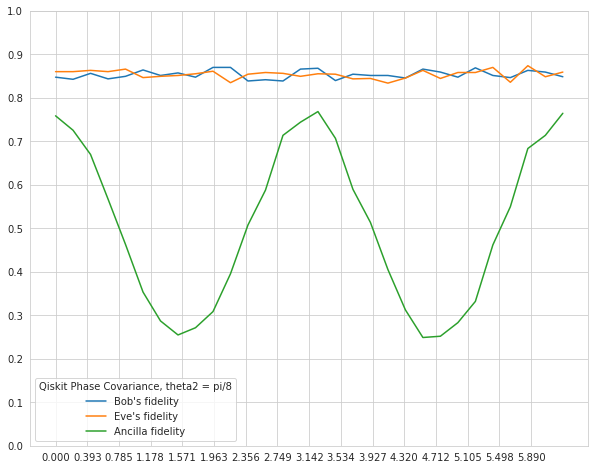

In [28]:
Phi = np.linspace(0, 2*np.pi, 30)

B = []
E = []
A = []

for k in range(len(Phi)):
    b, e, a = phase_covariance(np.pi/8, Phi[k], 1024)
    B.append(b)
    E.append(e)
    A.append(a)
    
B = np.array(B)
E = np.array(E)
A = np.array(A)

plt.figure(figsize=(10,8))
plt.plot(Phi, B, label = "Bob's fidelity")
plt.plot(Phi, E, label = "Eve's fidelity")
plt.plot(Phi, A, label = "Ancilla fidelity")
plt.yticks(np.arange(0,1.1, step = .1))
plt.xticks(np.arange(0, 2*np.pi, step = np.pi/8))
plt.legend(title="Qiskit Phase Covariance, theta2 = pi/8")
plt.show()